# Debris Detection for Formula One
Name: **William Newbould**

StudentID: **200415855**

---

## YOLOS (2021)

Provide Huggingface token.

In [1]:
!pip install huggingface_hub
from huggingface_hub import notebook_login
notebook_login()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 6.0 MB/s eta 0:00:00


Ensure GPU runtime.

In [2]:
!nvidia-smi

Wed Apr 26 09:44:17 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    47W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Installation

Install all requirements listed below.

In [3]:
!pip install -q ultralytics
!pip install -q transformers
!pip install -q pytorch-lightning
!pip install -q roboflow
!pip install -q timm
!pip install -q supervision==0.3.0
!pip install -q tqdm
!pip install -q evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 530.2/530.2 kB 23.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.5/199.5 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 96.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 105.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.0/719.0 kB 36.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 50.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 28.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.4/269.4 kB 35.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.2/56.2 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.4 MB/s eta 0:

### Imports

Import all required libraries.

In [4]:
import os
from IPython.display import Image
from roboflow import Roboflow
import torch
import torchvision
import roboflow
import supervision as sv
import transformers
from transformers import AutoModelForObjectDetection, AutoImageProcessor, AutoFeatureExtractor, Trainer, TrainingArguments
import random
import cv2
import numpy
import tqdm

TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]

print(
    "torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION,
    "\nroboflow:", roboflow.__version__, 
    "; supervision:", sv.__version__, 
    "; transformers:", transformers.__version__
)

torch:  2.0 ; cuda:  cu118 
roboflow: 1.0.5 ; supervision: 0.3.0 ; transformers: 4.28.1


### Import Data

Import the data from my Roboflow dataset.

In [5]:
rf = Roboflow(api_key="cznb3WnLwyvZTBr8tEpI")
project = rf.workspace("will-newbould-eifln").project("debris-detection-dataset-67jwg")
dataset = project.version(1).download("coco")

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to Debris-Detection-Dataset-1 in coco:: 100%|██████████| 14033/14033 [00:02<00:00, 5978.56it/s]


### Preparation

Then we register the dataset with the torchvision implementation of the COCO dataset format, and build the dataloader that we will later use in training.

In [6]:
# Register dataset as torchvision CocoDetection

class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, feature_extractor, train=True):
        ann_file = os.path.join(img_folder, "_annotations.coco.json")
        super(CocoDetection, self).__init__(img_folder, ann_file)
        self.feature_extractor = feature_extractor

    def __getitem__(self, idx):
        # read in PIL image and target in COCO format
        img, target = super(CocoDetection, self).__getitem__(idx)
        
        # preprocess image and target (converting target to DETR format, resizing + normalization of both image and target)
        image_id = self.ids[idx]
        target = {'image_id': image_id, 'annotations': target}
        encoding = self.feature_extractor(images=img, annotations=target, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze() # remove batch dimension
        target = encoding["labels"][0] # remove batch dimension

        return pixel_values, target

In [7]:
checkpoint = "hustvl/yolos-tiny"
feature_extractor = AutoFeatureExtractor.from_pretrained(checkpoint, size=512, max_size=864)

train_dataset = CocoDetection(img_folder=(dataset.location + '/train'), feature_extractor=feature_extractor)
test_dataset = CocoDetection(img_folder=(dataset.location + '/test'), feature_extractor=feature_extractor, train=False)
val_dataset = CocoDetection(img_folder=(dataset.location + '/valid'), feature_extractor=feature_extractor, train=False)

print("\nNumber of training examples:", len(train_dataset))
print("Number of testing examples:", len(test_dataset))
print("Number of validation examples:", len(val_dataset))

The class YolosFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use YolosImageProcessor instead.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


loading annotations into memory...
Done (t=0.10s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!

Number of training examples: 12372
Number of testing examples: 677
Number of validation examples: 976


Setup dataloader for training loop

In [8]:
from torch.utils.data import DataLoader

def collate_fn(batch):
  pixel_values = [item[0] for item in batch]
  encoding = feature_extractor.pad(pixel_values, return_tensors="pt")
  labels = [item[1] for item in batch]
  batch = {}
  batch['pixel_values'] = encoding['pixel_values']
  batch['labels'] = labels
  return batch

train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=1, shuffle=True)
test_dataloader = DataLoader(test_dataset, collate_fn=collate_fn, batch_size=1)
val_dataloader = DataLoader(val_dataset, collate_fn=collate_fn, batch_size=1)
batch = next(iter(train_dataloader))

### Display Image from training dataset with ground-truth detections.

Image n°1762


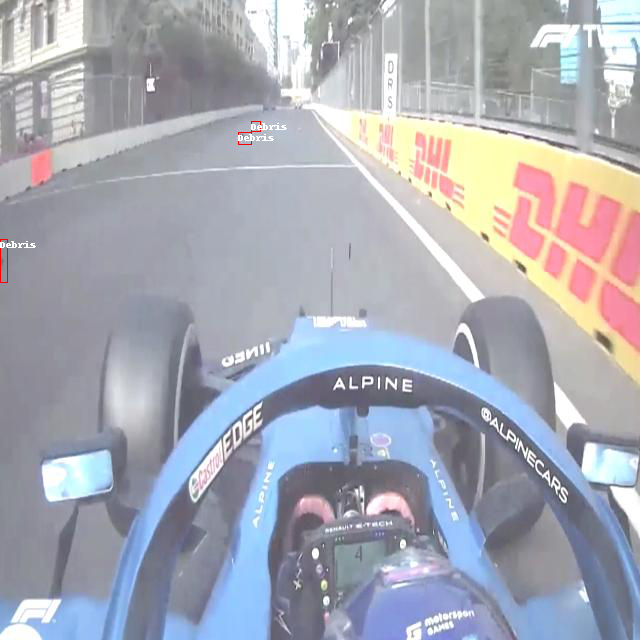

In [9]:
#Vizualize that our data has loaded correctly - You can hit this cell as many times as you want to vizualize how your training set has loaded
import numpy as np
import os
from PIL import Image, ImageDraw

# based on https://github.com/woctezuma/finetune-detr/blob/master/finetune_detr.ipynb
image_ids = train_dataset.coco.getImgIds()
# let's pick a random image
image_id = image_ids[np.random.randint(0, len(image_ids))]
print('Image n°{}'.format(image_id))
image = train_dataset.coco.loadImgs(image_id)[0]
image = Image.open(os.path.join(dataset.location + '/train', image['file_name']))

annotations = train_dataset.coco.imgToAnns[image_id]
draw = ImageDraw.Draw(image, "RGBA")

cats = train_dataset.coco.cats
id2label = {k: v['name'] for k,v in cats.items()}
label2id = {v: k for k, v in id2label.items()}

for annotation in annotations:
  box = annotation['bbox']
  class_idx = annotation['category_id']
  x,y,w,h = tuple(box)
  draw.rectangle((x,y,x+w,y+h), outline='red', width=1)
  draw.text((x, y), id2label[class_idx], fill='white')

image

### Define YOLOS Model 

Define the feature extractor and image porocessor using the YOLOS-small import.

In [10]:
from transformers import  YolosImageProcessor
# Instantiate the Image Processor
checkpoint = "hustvl/yolos-tiny"

feature_extractor = AutoFeatureExtractor.from_pretrained(checkpoint, size=512, max_size=864)
image_processor = YolosImageProcessor.from_pretrained(checkpoint)

Initialize the model.

In [11]:
from transformers import AutoModelForObjectDetection

model = AutoModelForObjectDetection.from_pretrained(
    checkpoint,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)

Some weights of YolosForObjectDetection were not initialized from the model checkpoint at hustvl/yolos-tiny and are newly initialized because the shapes did not match:
- class_labels_classifier.layers.2.weight: found shape torch.Size([92, 192]) in the checkpoint and torch.Size([5, 192]) in the model instantiated
- class_labels_classifier.layers.2.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([5]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Train YOLOS Model

Define training arguments for training the initial transformer model. We will initially train the transformer over 10 epochs.

In [12]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="detr-resnet-50_finetuned_cppe5",
    per_device_train_batch_size=16,
    num_train_epochs=15,
    save_steps=200,
    logging_steps=50,
    learning_rate=1e-5,
    weight_decay=1e-4
)

Begin training.

In [13]:
from transformers import Trainer

trainer = Trainer(model=model,
    args=training_args, 
    data_collator=collate_fn,
    train_dataset=train_dataset)

result = trainer.train()

This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning


### Save Model

In [14]:
HOME = os.getcwd()
MODEL_PATH = os.path.join(HOME, 'original-YOLOs-model')

In [15]:
model.save_pretrained(MODEL_PATH)

In [16]:
from transformers import YolosForObjectDetection, YolosImageProcessor
model = YolosForObjectDetection.from_pretrained(MODEL_PATH)
model.to('cpu')

YolosForObjectDetection(
  (vit): YolosModel(
    (embeddings): YolosEmbeddings(
      (patch_embeddings): YolosPatchEmbeddings(
        (projection): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
      (interpolation): InterpolateInitialPositionEmbeddings()
    )
    (encoder): YolosEncoder(
      (layer): ModuleList(
        (0-11): 12 x YolosLayer(
          (attention): YolosAttention(
            (attention): YolosSelfAttention(
              (query): Linear(in_features=192, out_features=192, bias=True)
              (key): Linear(in_features=192, out_features=192, bias=True)
              (value): Linear(in_features=192, out_features=192, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): YolosSelfOutput(
              (dense): Linear(in_features=192, out_features=192, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
        

In [17]:
torch.cuda.empty_cache()

### Evaluation  

Define categories of model

In [18]:
# convert ids to labels and labels to ids 
cats = test_dataset.coco.cats
id2label = {k: v['name'] for k,v in cats.items()}
label2id = {v: k for k, v in id2label.items()}

# create list of categories
categories= []
for i in range(1, len(cats)):
  categories.append(cats[i]['name'])

Actual Detections

Replicate above for actual detections and create an array of size 976 to store each image's actual detections.

In [19]:
# Validation dataset's detections
annotations = val_dataset.coco.imgToAnns

# Array to store all 1124 sets of detections
all_actual_labels = []

# Loop through every image in validation dataset
for index in range(0, len(val_dataloader)):

  # Temporary store for a given image's actual labels
  actual_labels = []

  # Loop through every detection in the given image
  for index2 in range(0, len(annotations[index])):
    actual_labels.append(annotations[index][index2]['category_id'])

  # Add image's actual labels to array
  all_actual_labels.append(actual_labels)

print(all_actual_labels)
print(len(all_actual_labels))

[[2, 2], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1], [2, 2, 2, 2, 2], [2, 2, 2, 2], [2, 1, 2], [2, 2, 2, 2, 2, 2], [2], [3, 2, 2, 2, 2, 2, 2], [1], [3], [2], [1], [3, 2], [1], [1], [3, 2, 2, 2, 2, 2, 2], [1, 1, 1], [2, 2], [2, 2], [1, 1], [1], [3], [2, 2], [1, 1, 1, 1, 1, 1], [1, 1], [1], [2, 2, 2, 2], [1], [2, 2], [1, 1, 1], [2, 2, 2], [1], [2], [2], [1], [2, 2, 2, 2, 2, 2], [2], [2, 2], [3, 2], [2, 3], [2, 2], [1, 1], [1, 1, 1, 2, 2], [1], [1, 3], [2, 2, 2, 2, 2], [3, 2], [2], [1, 1, 1, 1, 1], [2, 2, 2], [2], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1], [2, 2, 3], [2, 2, 3], [3, 2, 2], [3], [1], [2], [2, 2], [2], [2, 2], [2, 2], [2, 2, 3], [2, 2, 2], [1, 1], [2, 2], [3, 2], [3], [1, 1], [2, 2, 2], [3], [2], [1], [3], [1], [2, 2, 2], [1, 1], [1, 1], [2, 2], [1, 1, 1, 1, 1, 1], [2, 2, 2], [2, 2], [1, 1], [2], [2, 3], [1, 1, 1, 1], [3], [1, 1, 1, 1], [3, 2, 2], [1, 1, 1], [2, 2, 2, 2, 2, 2], [2, 2], [1, 1, 1], [1], [1, 1], [1], [1, 1, 1, 1], [1, 1], [1, 1, 1], [1, 1], 

In [22]:
CONFIDENCE_THRESHOLD = 0.5
IOU_THRESHOLDS = [0.95, 0.9, 0.85, 0.8, 0.75, 0.7, 0.65, 0.6, 0.55, 0.5]

precisions = []
recalls = []

for IOU in IOU_THRESHOLDS:
  
  prediction_labels = []

  print('\n\nWith an IOU threshold of:', str(IOU))

  with torch.no_grad():
    
    image_ids = val_dataset.coco.getImgIds()

    for image_id in image_ids:

      # load image
      image = val_dataset.coco.loadImgs(image_id)[0]
      image_path = os.path.join(val_dataset.root, image['file_name'])
      image = cv2.imread(image_path)

      inputs = image_processor(images=image, return_tensors='pt')
      outputs = model(**inputs)

      target_sizes = torch.tensor([image.shape[:2]])
      results = image_processor.post_process_object_detection(
          outputs=outputs,
          threshold=CONFIDENCE_THRESHOLD,
          target_sizes=target_sizes
      )[0]

      # Annotate
      if results['labels'].numpy() != []:
        detections = sv.Detections.from_transformers(transformers_results=results).with_nms(threshold=IOU)
        labels = detections.class_id
      else:
        labels = []

      prediction_labels.append(labels)
    

  # Array to store all 1124 sets of predictions
  all_predicted_labels = []

  # Loop through every image in validation dataset
  for index in range(0, len(val_dataset)):

    # Temporary store for a given image's predicted labels 
    predicted_labels = []

    # Loop through every detection in the given image
    for index2 in range(len(prediction_labels[index])):
      predicted_labels.append(prediction_labels[index][index2])

    # Add image's predicted labels to array
    all_predicted_labels.append(predicted_labels)

  print('Predicted labels:', all_predicted_labels)
  print('Actual Labels', all_actual_labels)

  all_precisions = []
  all_recalls = []

  # Define categories of model with extra category called 'Background' to indicate 
  # incorrect detectections
  categories_ids = [1,2,3]
  categories = ['Debris', 'Marshal', 'Recovery Vehicle']

  # Loop through each category
  for c in categories_ids:
    print('\nCategory:', id2label[c])
    # Create empty arrays to store precision and recall values
    category_precisions =[]
    category_recalls = []

    # Loop through each image in validation dataset
    for index in range(len(val_dataset)):  
      
      # Create temporary arrays to store the predicted and actual detections in the image
      temp_actual = all_actual_labels[index].copy()
      temp_predicted = all_predicted_labels[index].copy()

      # Count the number of times the category appears in both the actual and predicted detections 
      actual_count = temp_actual.count(c)
      predicted_count = temp_predicted.count(c)

      # Take the minimum value from the two counts
      # This value represents the number of detections of category c that the 
      # actual and predicted lists have in common.
      tp = min(actual_count, predicted_count)

      # Reduce the count by the number of matching detections to determine the 
      # number of category c detections left in each lists
      fn = actual_count - tp
      fp = predicted_count - tp

      if tp or fp > 0:
        precision = tp/(tp+fp)
        category_precisions.append(precision)
        
      if tp or fn > 0:
        recall = tp/(tp+fn)
        category_recalls.append(recall)

    # Calculate category precision and recall
    if len(category_precisions) != 0:
      category_precision = sum(category_precisions)/len(category_precisions)
    else:
      category_precision = 0

    if len(category_recalls) != 0:
      category_recall = sum(category_recalls)/len(category_recalls)
    else:
      category_recall = 0

    print(f'Precision: {category_precision}')
    print(f'Recall: {category_recall}')
    
    # Add category precisions and recalls to all precisions and recalls
    all_precisions.append(category_precision)
    all_recalls.append(category_recall)

  # Calculate precision and recall for the given IOU threshold
  total_precision = sum(all_precisions)/len(all_precisions)
  total_recall = sum(all_recalls)/len(all_recalls)

  print(f'\nOverall Precision: {total_precision}')
  print(f'Overall Recall: {total_recall}')

  precisions.append(total_precision)
  recalls.append(total_recall)

# Calculate precision and recall across all the IOU thresholds
precision = sum(precisions)/len(precisions)
recall = sum(recalls)/len(recalls)

print(f'\n\n\nmAP (50): {total_precision}')
print(f'Recall (50): {total_recall}')

print(f'\nmAP (50-95): {precision}')
print(f'Recall (50-95): {recall}')



With an IOU threshold of: 0.95


elementwise comparison failed; this will raise an error in the future.
The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


Predicted labels: [[2, 2], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1], [2, 2, 2, 2, 2, 2], [2, 2, 2, 2, 2, 2, 2], [], [2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2], [], [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [1, 1, 1, 1, 1, 1, 1], [3, 3], [], [1, 1], [2, 3], [1, 1], [1, 1, 1, 1, 1, 1, 1], [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [1, 1, 1, 1, 1, 1, 1, 1, 1], [2, 2, 2], [2, 2], [1, 1, 1, 1, 1], [], [], [2, 2], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1], [2, 2, 2, 2], [], [], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [2, 2, 2, 2, 2, 2, 2], [], [], [], [1, 1], [2, 2, 2, 2, 2, 2], [], [2, 2], [3, 3, 2, 3], [3, 1], [2, 2, 2, 2, 2], [1, 1, 1], [1, 2, 1, 1, 1, 2, 1, 1, 1], [1, 1, 1], [3, 1, 1, 1], [2, 2, 2, 2, 2, 2, 2], [2, 3], [2], [1, 1, 1], [2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

#### Confusion Matrix

Create two arrays, 'actual' and 'predicted' that between them store pairs of detections whether matching or not.


These arrays will be used to make a confusion matrix.

In [23]:
# Corresponding arrays to store each actual and predicted detections individually
# so to create pairs of corresponding actual and predicted detections
actual = []
predicted = []

# Define categories of model with extra category called 'Background' to indicate 
# incorrect detectections
categories_ids = [1,2,3,4]
categories = ['Debris', 'Marshal', 'Recovery Vehicle', 'background']

# Loop through every image in the valiation dataset
for index in range(0, len(val_dataset)):

  # Create temporary arrays to store the predicted and actual detections in the image
  temp_actual = all_actual_labels[index].copy()
  temp_predicted = all_predicted_labels[index].copy()

  # Loop through each category
  for c in categories_ids:
    # Count the number of times the category appears in both the actual and predicted detections 
    actual_count = temp_actual.count(c)
    predicted_count = temp_predicted.count(c)

    # Take the minimum value from the two counts
    # This value represents the number of detections of category c that the 
    # actual and predicted lists have in common.
    matching = min(actual_count, predicted_count)
    
    # Reduce the count by the number of matching detections to determine the 
    # number of category c detections left in each lists
    actual_count = actual_count- matching
    predicted_count = predicted_count - matching
    
    # For the number of shared detections add category c to both lists
    for i in range(matching):
      actual.append([c])
      predicted.append([c])

    # Determine number of remaining nonn-matched detections that were predicted 
    # but did not actual exist.
    not_actual = predicted_count
    for i in range(not_actual):
      # append the prediction to the predicted list and append 4 to the actual 
      # list to indicate incorrect detection.
      actual.append([4])
      predicted.append([c])

    not_predicted = actual_count
    for i in range(not_predicted):
      # append the detection to the actual list and append 4 to the predicted 
      # list to indicate incorrect detection.
      actual.append([c])
      predicted.append([4]) 


print('\nActual', actual)
print('Number of actual: ', len(actual))

print('Predicted', predicted)
print('Number of predicted: ', len(predicted))


Actual [[2], [2], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [1], [4], [2], [2], [2], [2], [2], [2], [2], [2], [2], [4], [4], [1], [2], [2], [4], [2], [2], [2], [2], [2], [2], [4], [4], [4], [2], [2], [2], [2], [2], [2], [2], [4], [4], [4], [3], [1], [4], [4], [4], [4], [4], [4], [3], [2], [1], [4], [2], [3], [1], [4], [1], [4], [4], [4], [4], [4], [2], [2], [2], [2], [2], [2], [4], [4], [3], [1], [1], [1], [4], [4], [4], [4], [2], [2], [4], [2], [2], [1], [1], [4], [4], [1], [3], [2], [2], [1], [1], [1], [1], [1], [1], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [1], [1], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [1], [4], [2], [2], [2], [2], [1], [2], [2], [1], [1], [1], [4], [4], [4], [4], [4], [2], [2], [2], [4], [1], [2], [2], [1], [4], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [3], [4], [2], [

Functions to make and annotate confusion matrix.

In [24]:
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix, classification_report

# The following functions are found and editted from: https://matplotlib.org/stable/gallery/images_contours_and_fields/image_annotated_heatmap.html

def heatmap(data, row_labels, col_labels, ax=None, cbar_kw={}, cbarlabel="", **kwargs):
    
    # Create a heatmap from a numpy array and two lists of labels.
    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="center")

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=False, bottom=True,
                   labeltop=False, labelbottom=True)
    # Show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # Label ticks with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels, rotation=90)

    ax.set_xlabel('True') 
    ax.set_ylabel('Predicted')
    
    return im, cbar


def annotate_heatmap(im, data=None, fmt="d", threshold=None):
    
    #  A function to annotate a heatmap.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            text = im.axes.text(j, i, format(data[i, j], fmt), horizontalalignment="center",
                                 color="black")
            texts.append(text)
    return texts

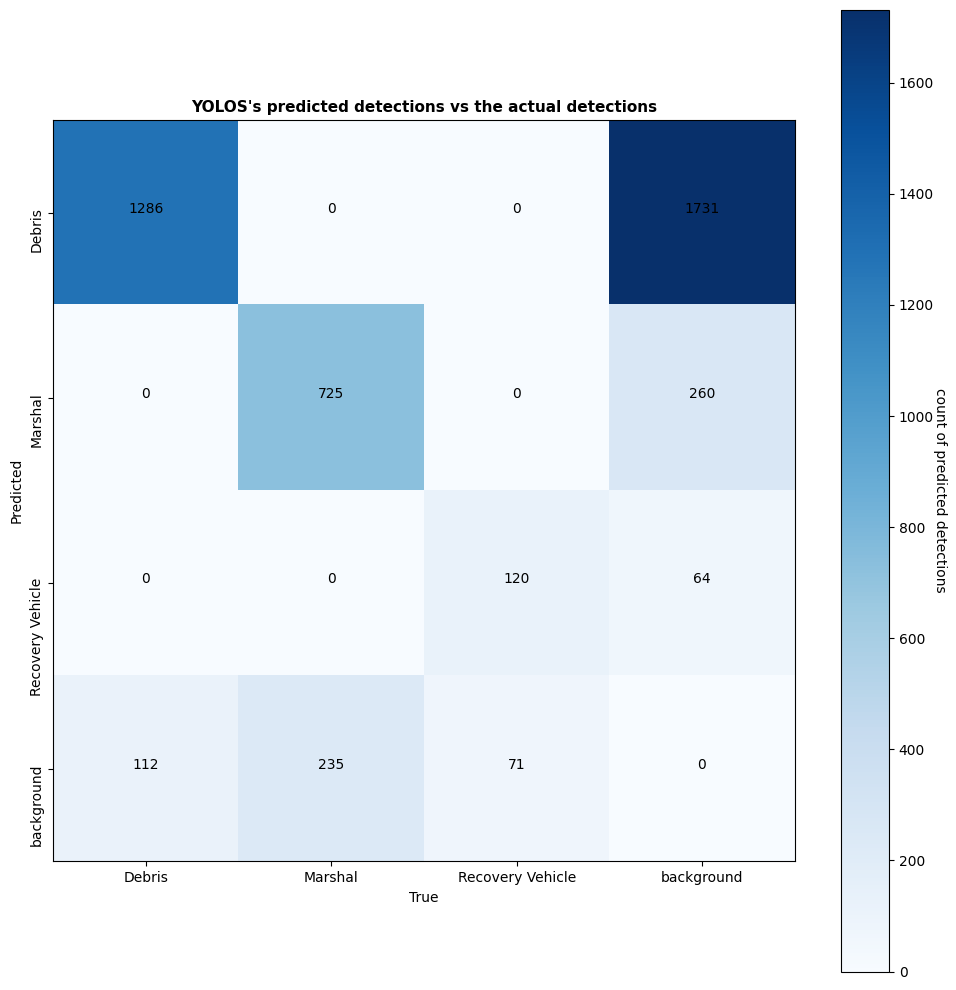

In [25]:
# Feed arrays of actual and predicted into confusion_matrix
cm = confusion_matrix(predicted, actual) 

# Plot confusion matrix 
fig, ax = plt.subplots(figsize=(10,10))
im, cbar = heatmap(cm, categories, categories, ax=ax,
                   cmap=plt.cm.Blues, cbarlabel="count of predicted detections")
texts = annotate_heatmap(im, data=cm)
plt.title("YOLOS's predicted detections vs the actual detections", fontweight='bold', fontsize=11)

fig.tight_layout()
plt.show()

### Validate YOLOS Model

Display the original image, the ground truth detections and the model's predictions for the same image.

Image #228
Original Image: 


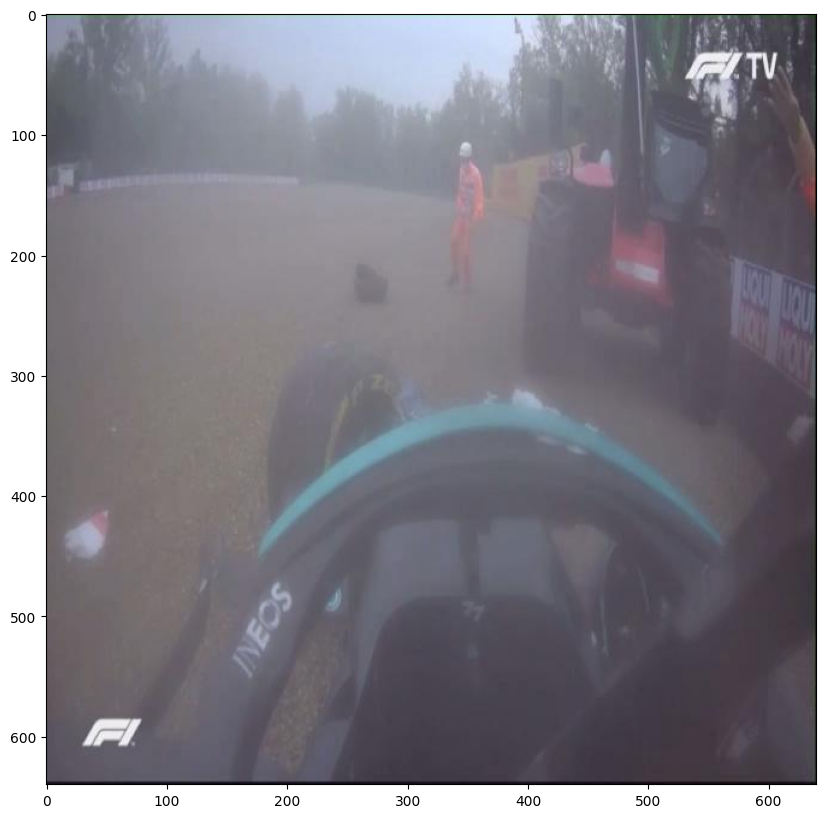

Ground truth: 


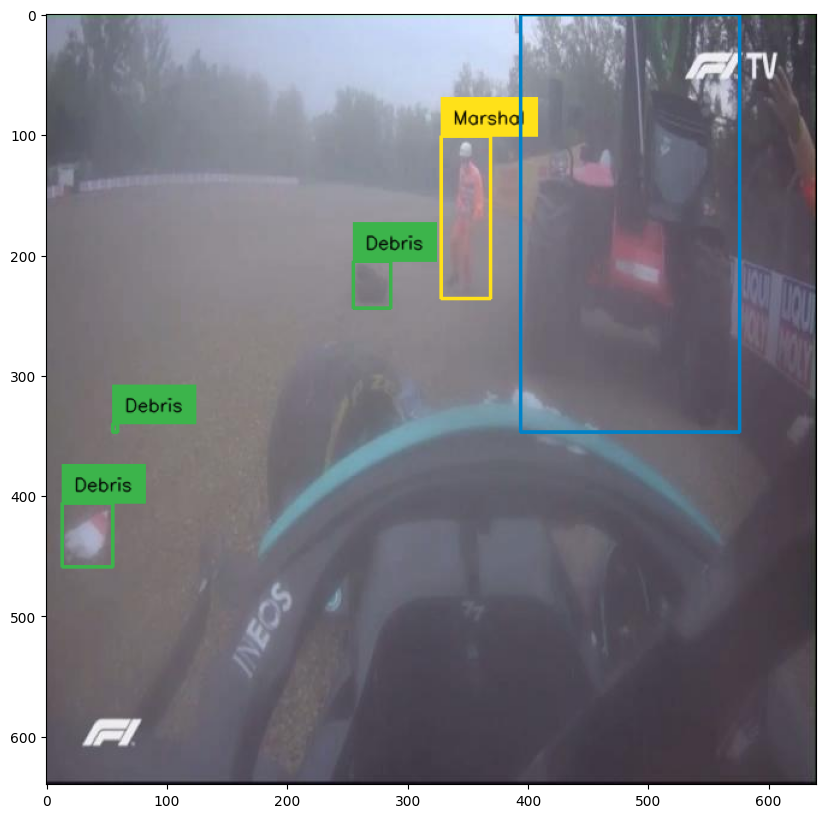

Number of Detections:  4
Prediction: 


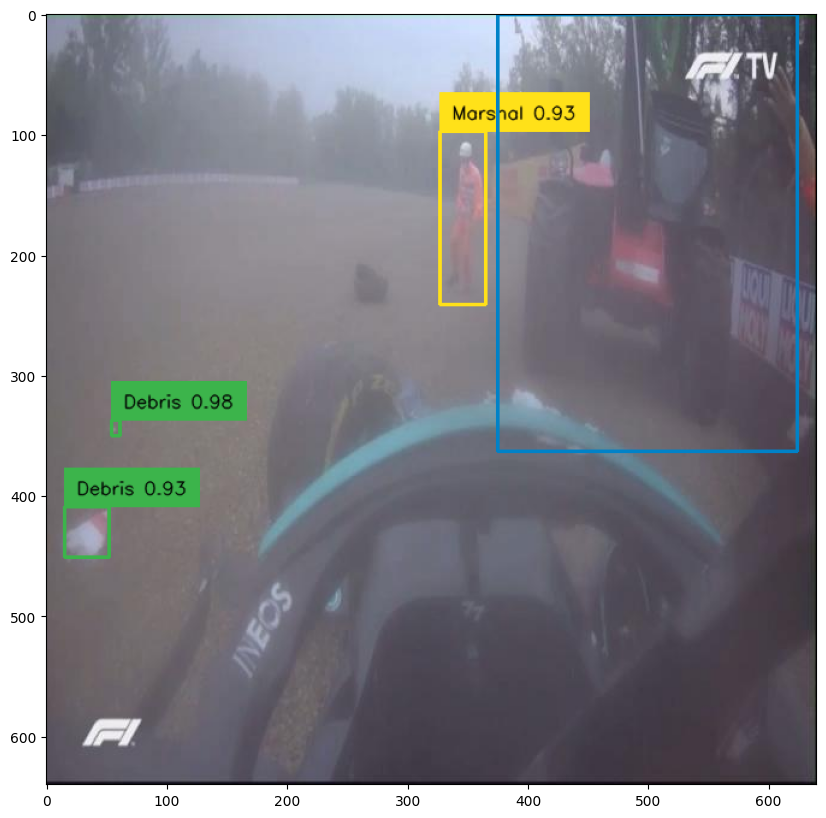

In [38]:
import random
import cv2
import numpy as np
import supervision as sv

device = 'cpu'
CONFIDENCE_THRESHOLD = 0.7
IOU_THRESHOLD = 0.5
image_processor = YolosImageProcessor.from_pretrained(checkpoint)

# utils
categories = val_dataset.coco.cats
id2label = {k: v['name'] for k,v in categories.items()}
box_annotator = sv.BoxAnnotator()

# select random image
image_ids = val_dataset.coco.getImgIds()
image_id = random.choice(image_ids)
print('Image #{}'.format(image_id))

# load image
image = val_dataset.coco.loadImgs(image_id)[0]
annotations = val_dataset.coco.imgToAnns[image_id]
image_path = os.path.join(val_dataset.root, image['file_name'])
image = cv2.imread(image_path)

print('Original Image: ')
%matplotlib inline  
sv.show_frame_in_notebook(image, (10, 10))

# Add ground truth annotations
detections = sv.Detections.from_coco_annotations(coco_annotation=annotations)
labels = [f"{id2label[class_id]}" for _, _, class_id, _ in detections]
frame = box_annotator.annotate(scene=image.copy(), detections=detections, labels=labels)

print('Ground truth: ')
%matplotlib inline  
sv.show_frame_in_notebook(frame, (10, 10))

# inference
with torch.no_grad():

    # load image and predict
    inputs = image_processor(images=image, return_tensors='pt').to(device)
    outputs = model(**inputs)

    # post-process
    target_sizes = torch.tensor([image.shape[:2]]).to(device)
    results = image_processor.post_process_object_detection(
        outputs=outputs, 
        threshold=CONFIDENCE_THRESHOLD, 
        target_sizes=target_sizes
    )[0]

print('Number of Detections: ', len(results['scores']))

# annotate
if len(results['scores']) == 0 :
  frame = image.copy()
else:
  detections = sv.Detections.from_transformers(transformers_results=results).with_nms(threshold=IOU_THRESHOLD)
  labels = [f"{id2label[class_id]} {confidence:.2f}" for _, confidence, class_id, _ in detections]
  frame = box_annotator.annotate(scene=image.copy(), detections=detections, labels=labels)

print('Prediction: ')
%matplotlib inline  
sv.show_frame_in_notebook(frame, (10, 10))

Trialing different confidence thresholds

Number of Detections:  100
Prediction with confidence threshold 0.0 : 


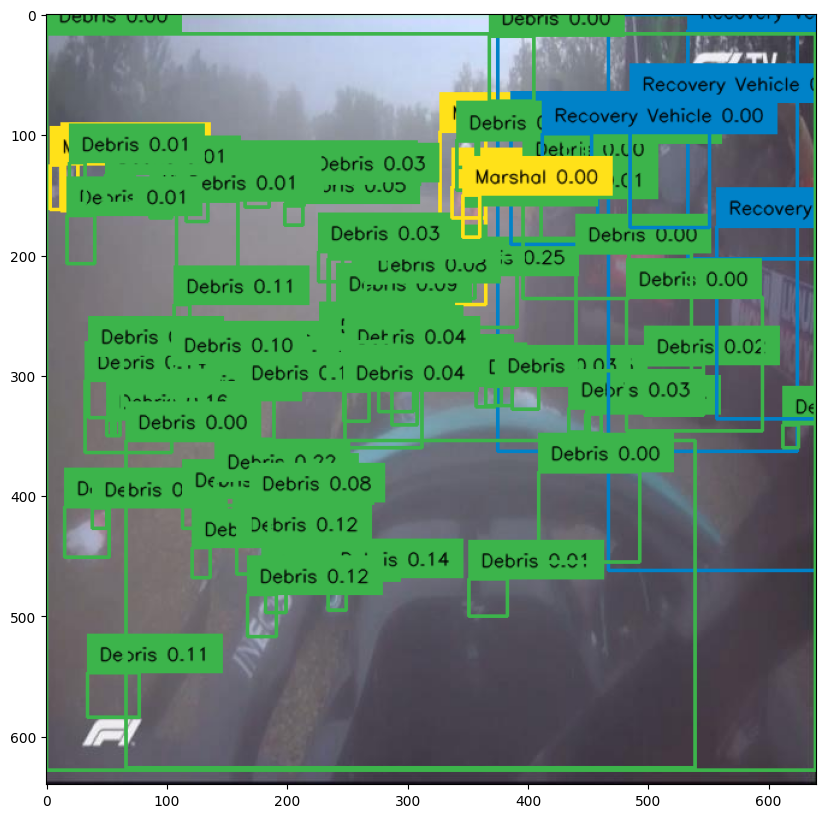

Number of Detections:  6
Prediction with confidence threshold 0.5 : 


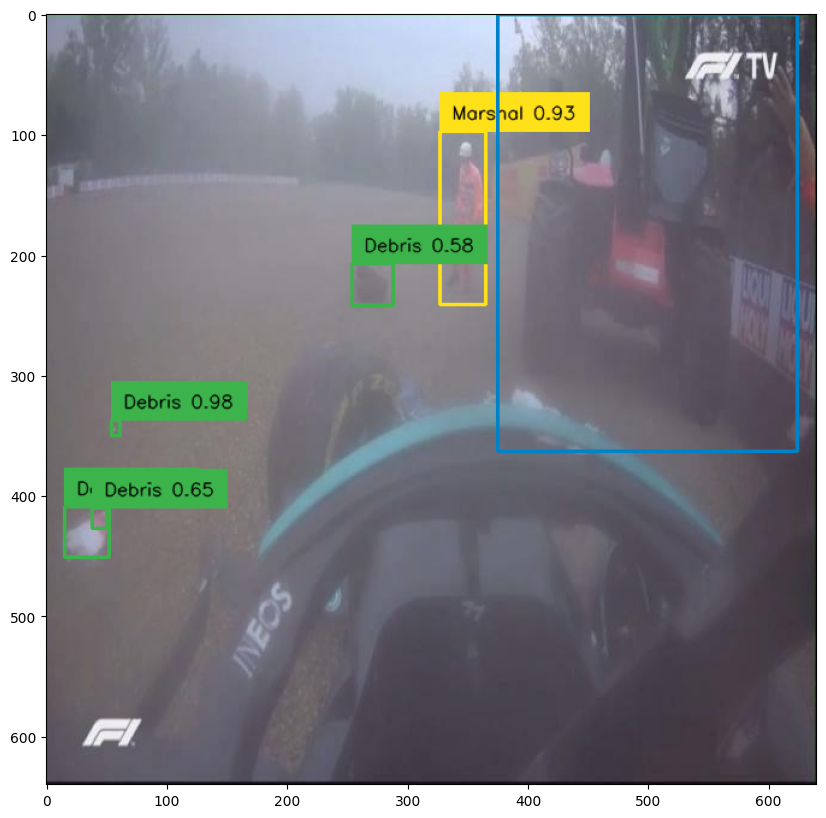

Number of Detections:  4
Prediction with confidence threshold 0.7 : 


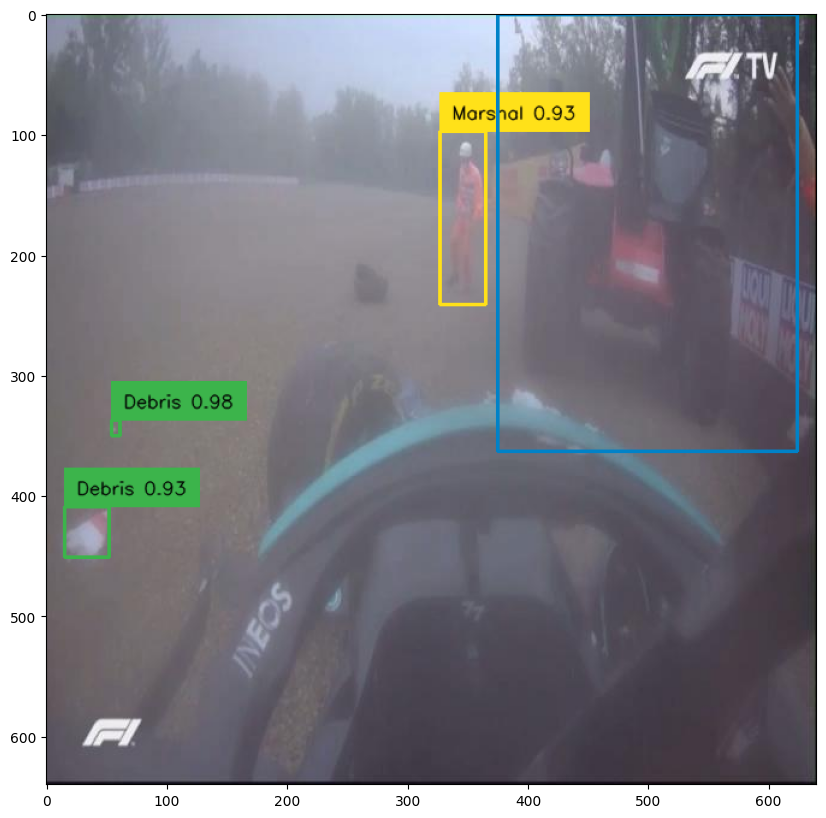

Number of Detections:  3
Prediction with confidence threshold 0.9 : 


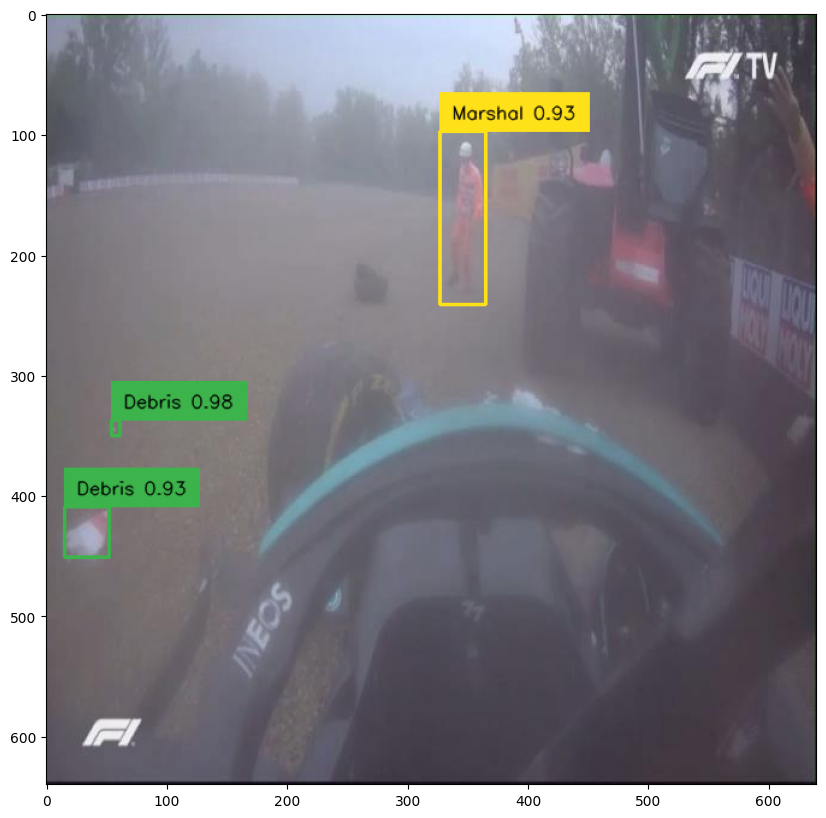

In [39]:
import random
import cv2
import numpy as np
import supervision as sv

device = 'cpu'
IOU_THRESHOLD = 0.5
image_processor = YolosImageProcessor.from_pretrained(checkpoint)

# utils
categories = val_dataset.coco.cats
id2label = {k: v['name'] for k,v in categories.items()}
box_annotator = sv.BoxAnnotator()

# Loop through different confidence thresholds
CONFIDENCE_THRESHOLDs = [0.0, 0.5, 0.7, 0.9]
for confidence in CONFIDENCE_THRESHOLDs:

  # inference
  with torch.no_grad():

      # load image and predict
      inputs = image_processor(images=image, return_tensors='pt').to(device)
      outputs = model(**inputs)

      # post-process
      target_sizes = torch.tensor([image.shape[:2]]).to(device)
      results = image_processor.post_process_object_detection(
          outputs=outputs, 
          threshold=confidence, 
          target_sizes=target_sizes
      )[0]

  print('Number of Detections: ', len(results['scores']))

  # annotate
  if len(results['scores']) == 0 :
    frame = image.copy()
  else:
    detections = sv.Detections.from_transformers(transformers_results=results).with_nms(threshold=IOU_THRESHOLD)
    labels = [f"{id2label[class_id]} {confidence:.2f}" for _, confidence, class_id, _ in detections]
    frame = box_annotator.annotate(scene=image.copy(), detections=detections, labels=labels)

  print('Prediction with confidence threshold', confidence,  ': ')
  %matplotlib inline  
  sv.show_frame_in_notebook(frame, (10, 10))

Trialing different IOU thresholds

Number of Detections:  11
Prediction with IOU threshold 0.0 : 


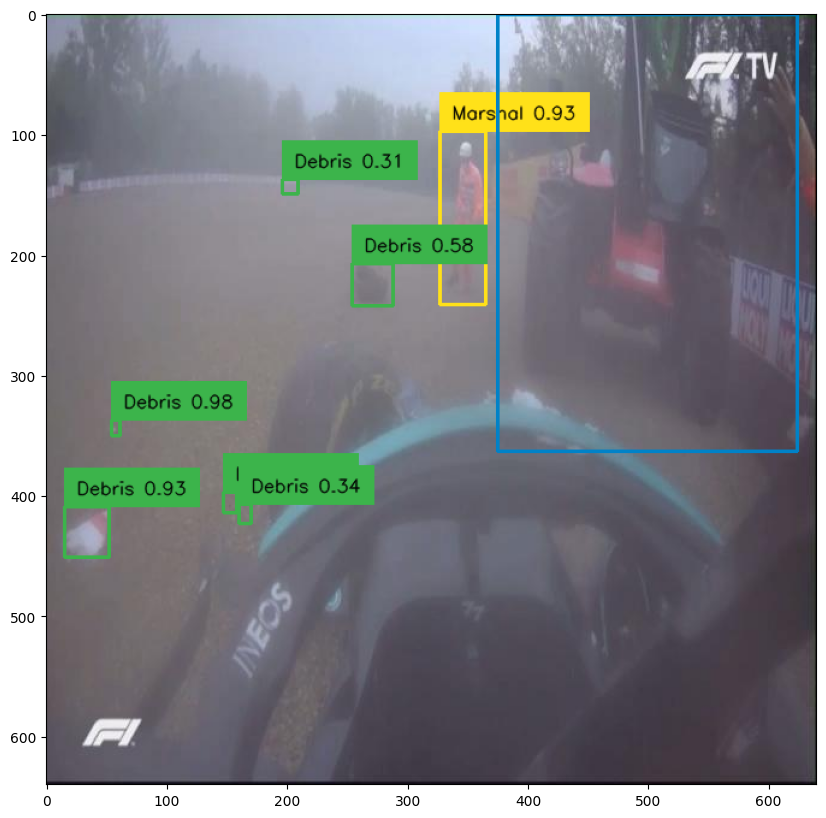

Number of Detections:  11
Prediction with IOU threshold 0.5 : 


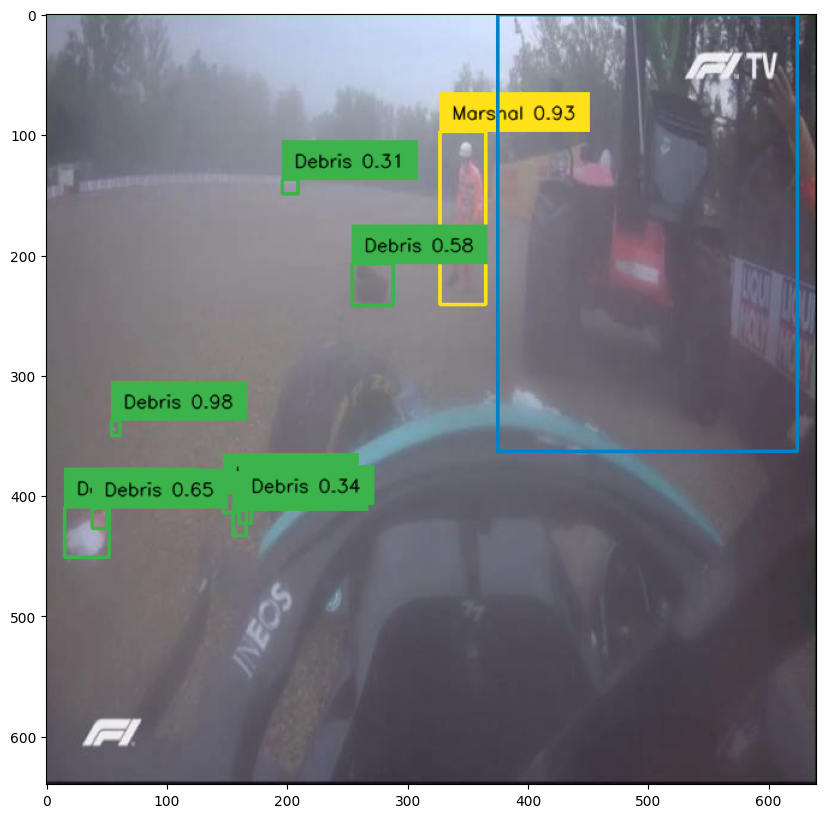

Number of Detections:  11
Prediction with IOU threshold 0.7 : 


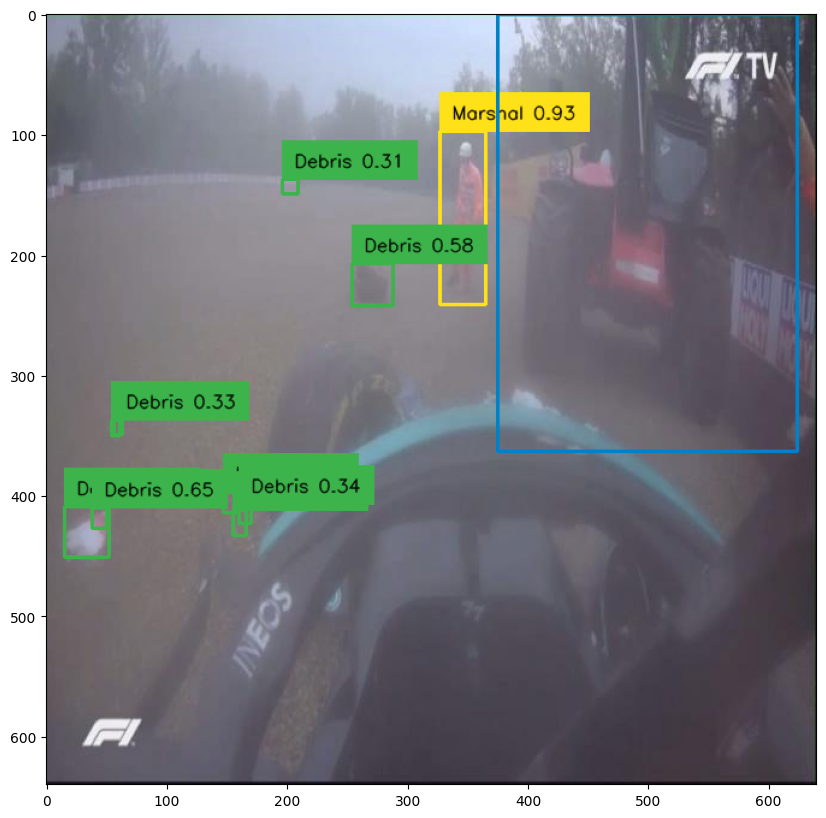

Number of Detections:  11
Prediction with IOU threshold 0.9 : 


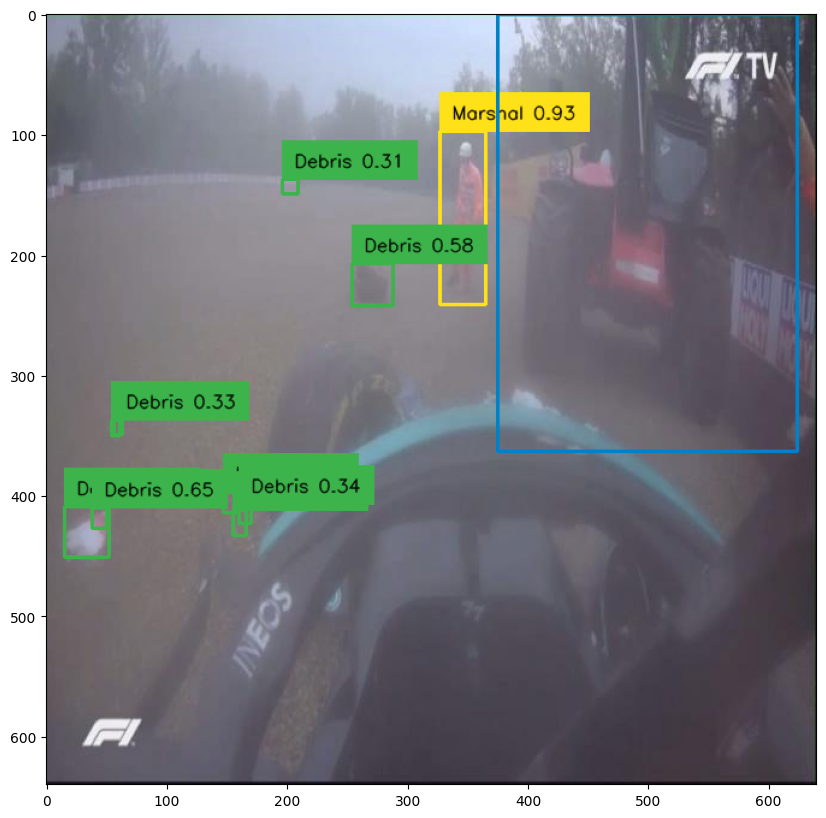

In [42]:
import random
import cv2
import numpy as np
import supervision as sv

device = 'cpu'
CONFIDENCE_THRESHOLD = 0.3
image_processor = YolosImageProcessor.from_pretrained(checkpoint)

# utils
categories = test_dataset.coco.cats
id2label = {k: v['name'] for k,v in categories.items()}
box_annotator = sv.BoxAnnotator()

# Loop through different confidence thresholds
IOU_THRESHOLDs = [0.0, 0.5, 0.7, 0.9]
for IOU in IOU_THRESHOLDs:

  # inference
  with torch.no_grad():

      # load image and predict
      inputs = image_processor(images=image, return_tensors='pt').to(device)
      outputs = model(**inputs)

      # post-process
      target_sizes = torch.tensor([image.shape[:2]]).to(device)
      results = image_processor.post_process_object_detection(
          outputs=outputs, 
          threshold=CONFIDENCE_THRESHOLD, 
          target_sizes=target_sizes
      )[0]

  print('Number of Detections: ', len(results['scores']))

  # annotate
  if len(results['scores']) == 0 :
    frame = image.copy()
  else:
    detections = sv.Detections.from_transformers(transformers_results=results).with_nms(threshold=IOU)
    labels = [f"{id2label[class_id]} {confidence:.2f}" for _, confidence, class_id, _ in detections]
    frame = box_annotator.annotate(scene=image.copy(), detections=detections, labels=labels)

  print('Prediction with IOU threshold', IOU,  ': ')
  %matplotlib inline  
  sv.show_frame_in_notebook(frame, (10, 10))

### Hyperparameter Search

Import Small Dataset

In [43]:
rf = Roboflow(api_key="BiTnmg5zTkGJyeI4pE1w")
project = rf.workspace("will-newbould-nnxbu").project("debris-detection-hyperparameter-training")
dataset_small = project.version(2).download("coco")

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to Debris-Detection-Hyperparameter-Training-2 in coco:: 100%|██████████| 2006/2006 [00:00<00:00, 5623.05it/s]


In [44]:
checkpoint = "hustvl/yolos-tiny"
feature_extractor = AutoFeatureExtractor.from_pretrained(checkpoint, size=512, max_size=864)

train_dataset_small = CocoDetection(img_folder=(dataset_small.location + '/train'), feature_extractor=feature_extractor)
val_dataset_small = CocoDetection(img_folder=(dataset_small.location + '/valid'), feature_extractor=feature_extractor, train=False)
test_dataset_small = CocoDetection(img_folder=(dataset_small.location + '/test'), feature_extractor=feature_extractor, train=False)

print("\nNumber of training examples:", len(train_dataset))
print("Number of validation examples:", len(val_dataset))
print("Number of testing examples:", len(test_dataset))

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!

Number of training examples: 12372
Number of validation examples: 976
Number of testing examples: 677


The class YolosFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use YolosImageProcessor instead.


In [45]:
! pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 30.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.9/212.9 kB 31.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 12.1 MB/s eta 0:00:00


In [46]:
import optuna

def optuna_hp_space(trial):
    return {
        "learning_rate": trial.suggest_float("learning_rate", 1e-6, 1e-4, log=True),
        "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [8, 16, 32]),
    }

In [47]:
def model_init(trial):
    return AutoModelForObjectDetection.from_pretrained(
        checkpoint,
        id2label=id2label,
        label2id=label2id,
        ignore_mismatched_sizes=True,
    )

In [48]:
training_args = TrainingArguments(
    output_dir="detr-resnet-50_finetuned_cppe5",
    save_steps=200,
    logging_steps=50,
    num_train_epochs=5,
    weight_decay=1e-4,
    save_total_limit=2
)

In [49]:
trainer = Trainer(
    model=None,
    args=training_args,
    train_dataset=train_dataset_small,
    eval_dataset=val_dataset_small,
    model_init=model_init,
    data_collator=collate_fn,
)

Some weights of YolosForObjectDetection were not initialized from the model checkpoint at hustvl/yolos-tiny and are newly initialized because the shapes did not match:
- class_labels_classifier.layers.2.weight: found shape torch.Size([92, 192]) in the checkpoint and torch.Size([5, 192]) in the model instantiated
- class_labels_classifier.layers.2.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([5]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [51]:
best_trial = trainer.hyperparameter_search(
    direction="minimize",
    backend="optuna",
    hp_space=optuna_hp_space,
    n_trials=20,
)

[I 2023-04-26 13:08:59,369] A new study created in memory with name: no-name-0f6e5e47-4338-4246-8b9c-461c1f413fb5
Some weights of YolosForObjectDetection were not initialized from the model checkpoint at hustvl/yolos-tiny and are newly initialized because the shapes did not match:
- class_labels_classifier.layers.2.weight: found shape torch.Size([92, 192]) in the checkpoint and torch.Size([5, 192]) in the model instantiated
- class_labels_classifier.layers.2.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([5]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[I 2023-04-26 13:13:00,681] Trial 0 finished with value: 2.01983380317688 and parameters: {'learning_rate': 9.694815840761107e-06, 'per_device_train_batch_size': 32}. Best is trial 0 with value: 2.01983380317688.
Some weights of YolosForObjectDetection were not initialized from the model checkpoint at hustvl/yolos-tiny and are newly initialized because the shapes did not match:
- class_labels_classifier.layers.2.weight: found shape torch.Size([92, 192]) in the checkpoint and torch.Size([5, 192]) in the model instantiated
- class_labels_classifier.layers.2.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([5]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning


[I 2023-04-26 13:17:12,598] Trial 1 finished with value: 2.6074273586273193 and parameters: {'learning_rate': 2.6958963033415806e-06, 'per_device_train_batch_size': 16}. Best is trial 0 with value: 2.01983380317688.
Some weights of YolosForObjectDetection were not initialized from the model checkpoint at hustvl/yolos-tiny and are newly initialized because the shapes did not match:
- class_labels_classifier.layers.2.weight: found shape torch.Size([92, 192]) in the checkpoint and torch.Size([5, 192]) in the model instantiated
- class_labels_classifier.layers.2.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([5]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning


[I 2023-04-26 13:21:16,621] Trial 2 finished with value: 1.5065845251083374 and parameters: {'learning_rate': 7.903729614993957e-05, 'per_device_train_batch_size': 32}. Best is trial 2 with value: 1.5065845251083374.
Some weights of YolosForObjectDetection were not initialized from the model checkpoint at hustvl/yolos-tiny and are newly initialized because the shapes did not match:
- class_labels_classifier.layers.2.weight: found shape torch.Size([92, 192]) in the checkpoint and torch.Size([5, 192]) in the model instantiated
- class_labels_classifier.layers.2.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([5]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning


[I 2023-04-26 13:25:35,539] Trial 3 finished with value: 1.9691760540008545 and parameters: {'learning_rate': 4.504520406369143e-06, 'per_device_train_batch_size': 8}. Best is trial 2 with value: 1.5065845251083374.
Some weights of YolosForObjectDetection were not initialized from the model checkpoint at hustvl/yolos-tiny and are newly initialized because the shapes did not match:
- class_labels_classifier.layers.2.weight: found shape torch.Size([92, 192]) in the checkpoint and torch.Size([5, 192]) in the model instantiated
- class_labels_classifier.layers.2.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([5]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning


[I 2023-04-26 13:29:59,990] Trial 4 finished with value: 1.6102019548416138 and parameters: {'learning_rate': 1.3803276630854692e-05, 'per_device_train_batch_size': 8}. Best is trial 2 with value: 1.5065845251083374.
Some weights of YolosForObjectDetection were not initialized from the model checkpoint at hustvl/yolos-tiny and are newly initialized because the shapes did not match:
- class_labels_classifier.layers.2.weight: found shape torch.Size([92, 192]) in the checkpoint and torch.Size([5, 192]) in the model instantiated
- class_labels_classifier.layers.2.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([5]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning


[I 2023-04-26 13:34:01,751] Trial 5 finished with value: 1.5096014738082886 and parameters: {'learning_rate': 6.940490465961251e-05, 'per_device_train_batch_size': 32}. Best is trial 2 with value: 1.5065845251083374.
Some weights of YolosForObjectDetection were not initialized from the model checkpoint at hustvl/yolos-tiny and are newly initialized because the shapes did not match:
- class_labels_classifier.layers.2.weight: found shape torch.Size([92, 192]) in the checkpoint and torch.Size([5, 192]) in the model instantiated
- class_labels_classifier.layers.2.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([5]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning


[I 2023-04-26 13:38:23,114] Trial 6 finished with value: 1.4586936235427856 and parameters: {'learning_rate': 5.2245387677112016e-05, 'per_device_train_batch_size': 8}. Best is trial 6 with value: 1.4586936235427856.
Some weights of YolosForObjectDetection were not initialized from the model checkpoint at hustvl/yolos-tiny and are newly initialized because the shapes did not match:
- class_labels_classifier.layers.2.weight: found shape torch.Size([92, 192]) in the checkpoint and torch.Size([5, 192]) in the model instantiated
- class_labels_classifier.layers.2.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([5]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning


[I 2023-04-26 13:42:32,264] Trial 7 finished with value: 2.0866003036499023 and parameters: {'learning_rate': 5.373237354646094e-06, 'per_device_train_batch_size': 16}. Best is trial 6 with value: 1.4586936235427856.
Some weights of YolosForObjectDetection were not initialized from the model checkpoint at hustvl/yolos-tiny and are newly initialized because the shapes did not match:
- class_labels_classifier.layers.2.weight: found shape torch.Size([92, 192]) in the checkpoint and torch.Size([5, 192]) in the model instantiated
- class_labels_classifier.layers.2.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([5]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning


[I 2023-04-26 13:46:32,948] Trial 8 finished with value: 1.6908005475997925 and parameters: {'learning_rate': 2.3230010071411735e-05, 'per_device_train_batch_size': 32}. Best is trial 6 with value: 1.4586936235427856.
Some weights of YolosForObjectDetection were not initialized from the model checkpoint at hustvl/yolos-tiny and are newly initialized because the shapes did not match:
- class_labels_classifier.layers.2.weight: found shape torch.Size([92, 192]) in the checkpoint and torch.Size([5, 192]) in the model instantiated
- class_labels_classifier.layers.2.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([5]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning


[I 2023-04-26 13:50:53,210] Trial 9 finished with value: 1.464066505432129 and parameters: {'learning_rate': 7.219148958218316e-05, 'per_device_train_batch_size': 8}. Best is trial 6 with value: 1.4586936235427856.
Some weights of YolosForObjectDetection were not initialized from the model checkpoint at hustvl/yolos-tiny and are newly initialized because the shapes did not match:
- class_labels_classifier.layers.2.weight: found shape torch.Size([92, 192]) in the checkpoint and torch.Size([5, 192]) in the model instantiated
- class_labels_classifier.layers.2.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([5]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning


[I 2023-04-26 13:55:12,244] Trial 10 finished with value: 2.6958844661712646 and parameters: {'learning_rate': 1.3295994103688548e-06, 'per_device_train_batch_size': 8}. Best is trial 6 with value: 1.4586936235427856.
Some weights of YolosForObjectDetection were not initialized from the model checkpoint at hustvl/yolos-tiny and are newly initialized because the shapes did not match:
- class_labels_classifier.layers.2.weight: found shape torch.Size([92, 192]) in the checkpoint and torch.Size([5, 192]) in the model instantiated
- class_labels_classifier.layers.2.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([5]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning


[I 2023-04-26 13:59:31,602] Trial 11 finished with value: 1.4322336912155151 and parameters: {'learning_rate': 4.4854310813914375e-05, 'per_device_train_batch_size': 8}. Best is trial 11 with value: 1.4322336912155151.
Some weights of YolosForObjectDetection were not initialized from the model checkpoint at hustvl/yolos-tiny and are newly initialized because the shapes did not match:
- class_labels_classifier.layers.2.weight: found shape torch.Size([92, 192]) in the checkpoint and torch.Size([5, 192]) in the model instantiated
- class_labels_classifier.layers.2.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([5]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning


[I 2023-04-26 14:03:50,360] Trial 12 finished with value: 1.4185545444488525 and parameters: {'learning_rate': 3.5356176490655605e-05, 'per_device_train_batch_size': 8}. Best is trial 12 with value: 1.4185545444488525.
Some weights of YolosForObjectDetection were not initialized from the model checkpoint at hustvl/yolos-tiny and are newly initialized because the shapes did not match:
- class_labels_classifier.layers.2.weight: found shape torch.Size([92, 192]) in the checkpoint and torch.Size([5, 192]) in the model instantiated
- class_labels_classifier.layers.2.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([5]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning


[I 2023-04-26 14:08:09,680] Trial 13 finished with value: 1.4640791416168213 and parameters: {'learning_rate': 3.160480830968016e-05, 'per_device_train_batch_size': 8}. Best is trial 12 with value: 1.4185545444488525.
Some weights of YolosForObjectDetection were not initialized from the model checkpoint at hustvl/yolos-tiny and are newly initialized because the shapes did not match:
- class_labels_classifier.layers.2.weight: found shape torch.Size([92, 192]) in the checkpoint and torch.Size([5, 192]) in the model instantiated
- class_labels_classifier.layers.2.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([5]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning


[I 2023-04-26 14:12:30,926] Trial 14 finished with value: 1.465691328048706 and parameters: {'learning_rate': 3.181146876402364e-05, 'per_device_train_batch_size': 8}. Best is trial 12 with value: 1.4185545444488525.
Some weights of YolosForObjectDetection were not initialized from the model checkpoint at hustvl/yolos-tiny and are newly initialized because the shapes did not match:
- class_labels_classifier.layers.2.weight: found shape torch.Size([92, 192]) in the checkpoint and torch.Size([5, 192]) in the model instantiated
- class_labels_classifier.layers.2.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([5]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning


[I 2023-04-26 14:16:51,748] Trial 15 finished with value: 1.479225516319275 and parameters: {'learning_rate': 9.647737446185511e-05, 'per_device_train_batch_size': 8}. Best is trial 12 with value: 1.4185545444488525.
Some weights of YolosForObjectDetection were not initialized from the model checkpoint at hustvl/yolos-tiny and are newly initialized because the shapes did not match:
- class_labels_classifier.layers.2.weight: found shape torch.Size([92, 192]) in the checkpoint and torch.Size([5, 192]) in the model instantiated
- class_labels_classifier.layers.2.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([5]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning


[I 2023-04-26 14:20:59,743] Trial 16 finished with value: 1.5021499395370483 and parameters: {'learning_rate': 4.287476389338967e-05, 'per_device_train_batch_size': 16}. Best is trial 12 with value: 1.4185545444488525.
Some weights of YolosForObjectDetection were not initialized from the model checkpoint at hustvl/yolos-tiny and are newly initialized because the shapes did not match:
- class_labels_classifier.layers.2.weight: found shape torch.Size([92, 192]) in the checkpoint and torch.Size([5, 192]) in the model instantiated
- class_labels_classifier.layers.2.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([5]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning


[I 2023-04-26 14:25:24,095] Trial 17 finished with value: 1.5297869443893433 and parameters: {'learning_rate': 1.987470200556153e-05, 'per_device_train_batch_size': 8}. Best is trial 12 with value: 1.4185545444488525.
Some weights of YolosForObjectDetection were not initialized from the model checkpoint at hustvl/yolos-tiny and are newly initialized because the shapes did not match:
- class_labels_classifier.layers.2.weight: found shape torch.Size([92, 192]) in the checkpoint and torch.Size([5, 192]) in the model instantiated
- class_labels_classifier.layers.2.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([5]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning


[I 2023-04-26 14:29:44,719] Trial 18 finished with value: 1.480429768562317 and parameters: {'learning_rate': 4.291366698525339e-05, 'per_device_train_batch_size': 8}. Best is trial 12 with value: 1.4185545444488525.
Some weights of YolosForObjectDetection were not initialized from the model checkpoint at hustvl/yolos-tiny and are newly initialized because the shapes did not match:
- class_labels_classifier.layers.2.weight: found shape torch.Size([92, 192]) in the checkpoint and torch.Size([5, 192]) in the model instantiated
- class_labels_classifier.layers.2.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([5]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning


[I 2023-04-26 14:33:55,991] Trial 19 finished with value: 1.658686637878418 and parameters: {'learning_rate': 1.5523210670106018e-05, 'per_device_train_batch_size': 16}. Best is trial 12 with value: 1.4185545444488525.


In [52]:
torch.cuda.empty_cache()

### Re-use best trial to re-train model

Define the feature extractor and image porocessor using the YOLOS-small import.

In [53]:
from transformers import  YolosImageProcessor
# Instantiate the Image Processor
checkpoint = "hustvl/yolos-tiny"

feature_extractor = AutoFeatureExtractor.from_pretrained(checkpoint, size=512, max_size=864)
image_processor = YolosImageProcessor.from_pretrained(checkpoint)

The class YolosFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use YolosImageProcessor instead.


Initialize the model.

In [54]:
from transformers import AutoModelForObjectDetection

model_tuned = AutoModelForObjectDetection.from_pretrained(
    checkpoint,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)

Some weights of YolosForObjectDetection were not initialized from the model checkpoint at hustvl/yolos-tiny and are newly initialized because the shapes did not match:
- class_labels_classifier.layers.2.weight: found shape torch.Size([92, 192]) in the checkpoint and torch.Size([5, 192]) in the model instantiated
- class_labels_classifier.layers.2.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([5]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Define training arguments for training the initial transformer model. We will initially train the transformer over 10 epochs.

In [55]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="detr-resnet-50_finetuned_cppe5",
    per_device_train_batch_size=best_trial.hyperparameters['per_device_train_batch_size'],
    learning_rate=best_trial.hyperparameters['learning_rate'],
    num_train_epochs=15,
    save_steps=200,
    logging_steps=50,
    weight_decay=1e-4
)

Begin training.

In [56]:
from transformers import Trainer

trainer = Trainer(model=model_tuned,
    args=training_args, 
    data_collator=collate_fn,
    train_dataset=train_dataset)

result = trainer.train()

This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning


#### Save Model

In [57]:
HOME = os.getcwd()
MODEL_PATH = os.path.join(HOME, 'tuned-YOLOs-model')

In [58]:
model_tuned.save_pretrained(MODEL_PATH)

In [59]:
from transformers import YolosForObjectDetection, YolosImageProcessor
model_tuned = YolosForObjectDetection.from_pretrained(MODEL_PATH)
model_tuned.to('cpu')

YolosForObjectDetection(
  (vit): YolosModel(
    (embeddings): YolosEmbeddings(
      (patch_embeddings): YolosPatchEmbeddings(
        (projection): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
      (interpolation): InterpolateInitialPositionEmbeddings()
    )
    (encoder): YolosEncoder(
      (layer): ModuleList(
        (0-11): 12 x YolosLayer(
          (attention): YolosAttention(
            (attention): YolosSelfAttention(
              (query): Linear(in_features=192, out_features=192, bias=True)
              (key): Linear(in_features=192, out_features=192, bias=True)
              (value): Linear(in_features=192, out_features=192, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): YolosSelfOutput(
              (dense): Linear(in_features=192, out_features=192, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
        

In [60]:
torch.cuda.empty_cache()

### Evaluation  

Define categories of model

In [61]:
# convert ids to labels and labels to ids 
cats = test_dataset.coco.cats
id2label = {k: v['name'] for k,v in cats.items()}
label2id = {v: k for k, v in id2label.items()}

# create list of categories
categories= []
for i in range(1, len(cats)):
  categories.append(cats[i]['name'])

Actual Detections

Replicate above for actual detections and create an array of size 976 to store each image's actual detections.

In [62]:
# Validation dataset's detections
annotations = val_dataset.coco.imgToAnns

# Array to store all 1124 sets of detections
all_actual_labels = []

# Loop through every image in validation dataset
for index in range(0, len(val_dataloader)):

  # Temporary store for a given image's actual labels
  actual_labels = []

  # Loop through every detection in the given image
  for index2 in range(0, len(annotations[index])):
    actual_labels.append(annotations[index][index2]['category_id'])

  # Add image's actual labels to array
  all_actual_labels.append(actual_labels)

print(all_actual_labels)
print(len(all_actual_labels))

[[2, 2], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1], [2, 2, 2, 2, 2], [2, 2, 2, 2], [2, 1, 2], [2, 2, 2, 2, 2, 2], [2], [3, 2, 2, 2, 2, 2, 2], [1], [3], [2], [1], [3, 2], [1], [1], [3, 2, 2, 2, 2, 2, 2], [1, 1, 1], [2, 2], [2, 2], [1, 1], [1], [3], [2, 2], [1, 1, 1, 1, 1, 1], [1, 1], [1], [2, 2, 2, 2], [1], [2, 2], [1, 1, 1], [2, 2, 2], [1], [2], [2], [1], [2, 2, 2, 2, 2, 2], [2], [2, 2], [3, 2], [2, 3], [2, 2], [1, 1], [1, 1, 1, 2, 2], [1], [1, 3], [2, 2, 2, 2, 2], [3, 2], [2], [1, 1, 1, 1, 1], [2, 2, 2], [2], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1], [2, 2, 3], [2, 2, 3], [3, 2, 2], [3], [1], [2], [2, 2], [2], [2, 2], [2, 2], [2, 2, 3], [2, 2, 2], [1, 1], [2, 2], [3, 2], [3], [1, 1], [2, 2, 2], [3], [2], [1], [3], [1], [2, 2, 2], [1, 1], [1, 1], [2, 2], [1, 1, 1, 1, 1, 1], [2, 2, 2], [2, 2], [1, 1], [2], [2, 3], [1, 1, 1, 1], [3], [1, 1, 1, 1], [3, 2, 2], [1, 1, 1], [2, 2, 2, 2, 2, 2], [2, 2], [1, 1, 1], [1], [1, 1], [1], [1, 1, 1, 1], [1, 1], [1, 1, 1], [1, 1], 

In [63]:
CONFIDENCE_THRESHOLD = 0.5
IOU_THRESHOLDS = [0.95, 0.9, 0.85, 0.8, 0.75, 0.7, 0.65, 0.6, 0.55, 0.5]

precisions = []
recalls = []

for IOU in IOU_THRESHOLDS:
  
  prediction_labels = []

  print('\n\nWith an IOU threshold of:', str(IOU))

  with torch.no_grad():
    
    image_ids = val_dataset.coco.getImgIds()

    for image_id in image_ids:

      # load image
      image = val_dataset.coco.loadImgs(image_id)[0]
      image_path = os.path.join(val_dataset.root, image['file_name'])
      image = cv2.imread(image_path)

      inputs = image_processor(images=image, return_tensors='pt')
      outputs = model_tuned(**inputs)

      target_sizes = torch.tensor([image.shape[:2]])
      results = image_processor.post_process_object_detection(
          outputs=outputs,
          threshold=CONFIDENCE_THRESHOLD,
          target_sizes=target_sizes
      )[0]

      # Annotate
      if results['labels'].numpy() != []:
        detections = sv.Detections.from_transformers(transformers_results=results).with_nms(threshold=IOU)
        labels = detections.class_id
      else:
        labels = []

      prediction_labels.append(labels)
    

  # Array to store all 1124 sets of predictions
  all_predicted_labels = []

  # Loop through every image in validation dataset
  for index in range(0, len(val_dataset)):

    # Temporary store for a given image's predicted labels 
    predicted_labels = []

    # Loop through every detection in the given image
    for index2 in range(len(prediction_labels[index])):
      predicted_labels.append(prediction_labels[index][index2])

    # Add image's predicted labels to array
    all_predicted_labels.append(predicted_labels)

  print('Predicted labels:', all_predicted_labels)
  print('Actual Labels', all_actual_labels)

  all_precisions = []
  all_recalls = []

  # Define categories of model with extra category called 'Background' to indicate 
  # incorrect detectections
  categories_ids = [1,2,3]
  categories = ['Debris', 'Marshal', 'Recovery Vehicle']

  # Loop through each category
  for c in categories_ids:
    print('\nCategory:', id2label[c])
    # Create empty arrays to store precision and recall values
    category_precisions =[]
    category_recalls = []

    # Loop through each image in validation dataset
    for index in range(len(val_dataset)):  
      
      # Create temporary arrays to store the predicted and actual detections in the image
      temp_actual = all_actual_labels[index].copy()
      temp_predicted = all_predicted_labels[index].copy()

      # Count the number of times the category appears in both the actual and predicted detections 
      actual_count = temp_actual.count(c)
      predicted_count = temp_predicted.count(c)

      # Take the minimum value from the two counts
      # This value represents the number of detections of category c that the 
      # actual and predicted lists have in common.
      tp = min(actual_count, predicted_count)

      # Reduce the count by the number of matching detections to determine the 
      # number of category c detections left in each lists
      fn = actual_count - tp
      fp = predicted_count - tp

      if tp or fp > 0:
        precision = tp/(tp+fp)
        category_precisions.append(precision)
        
      if tp or fn > 0:
        recall = tp/(tp+fn)
        category_recalls.append(recall)

    # Calculate category precision and recall
    if len(category_precisions) != 0:
      category_precision = sum(category_precisions)/len(category_precisions)
    else:
      category_precision = 0

    if len(category_recalls) != 0:
      category_recall = sum(category_recalls)/len(category_recalls)
    else:
      category_recall = 0

    print(f'Precision: {category_precision}')
    print(f'Recall: {category_recall}')
    
    # Add category precisions and recalls to all precisions and recalls
    all_precisions.append(category_precision)
    all_recalls.append(category_recall)

  # Calculate precision and recall for the given IOU threshold
  total_precision = sum(all_precisions)/len(all_precisions)
  total_recall = sum(all_recalls)/len(all_recalls)

  print(f'\nOverall Precision: {total_precision}')
  print(f'Overall Recall: {total_recall}')

  precisions.append(total_precision)
  recalls.append(total_recall)

# Calculate precision and recall across all the IOU thresholds
precision = sum(precisions)/len(precisions)
recall = sum(recalls)/len(recalls)

print(f'\n\n\nmAP (50): {total_precision}')
print(f'Recall (50): {total_recall}')

print(f'\nmAP (50-95): {precision}')
print(f'Recall (50-95): {recall}')



With an IOU threshold of: 0.95


elementwise comparison failed; this will raise an error in the future.
The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


Predicted labels: [[2, 2], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [], [2, 2, 2], [2, 2, 2, 2, 2, 2, 2, 2], [], [2, 2, 2, 2, 2, 2, 2, 2, 2], [], [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2], [1, 1, 1, 1, 1, 1, 1, 1], [], [], [1, 1], [2, 3, 1], [1, 1, 1], [1, 1], [2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 3, 2], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [2, 2], [2, 2, 2], [], [], [3, 3], [2, 2], [1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1], [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [], [], [1, 1, 1, 1, 1, 1, 1, 1], [2, 2, 2, 2], [1, 1], [], [], [], [2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [2, 3], [2, 2], [3, 2], [], [2, 2], [1, 1], [1, 1, 2, 1, 1, 1], [1, 1, 1, 1], [3, 1, 3, 1], [2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [3, 2], [], [1, 1], [2, 2, 2, 2, 2, 2], [], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1], [2,

#### Confusion Matrix

Create two arrays, 'actual' and 'predicted' that between them store pairs of detections whether matching or not.


These arrays will be used to make a confusion matrix.

In [64]:
# Corresponding arrays to store each actual and predicted detections individually
# so to create pairs of corresponding actual and predicted detections
actual = []
predicted = []

# Define categories of model with extra category called 'Background' to indicate 
# incorrect detectections
categories_ids = [1,2,3,4]
categories = ['Debris', 'Marshal', 'Recovery Vehicle', 'background']

# Loop through every image in the valiation dataset
for index in range(0, len(val_dataset)):

  # Create temporary arrays to store the predicted and actual detections in the image
  temp_actual = all_actual_labels[index].copy()
  temp_predicted = all_predicted_labels[index].copy()

  # Loop through each category
  for c in categories_ids:
    # Count the number of times the category appears in both the actual and predicted detections 
    actual_count = temp_actual.count(c)
    predicted_count = temp_predicted.count(c)

    # Take the minimum value from the two counts
    # This value represents the number of detections of category c that the 
    # actual and predicted lists have in common.
    matching = min(actual_count, predicted_count)
    
    # Reduce the count by the number of matching detections to determine the 
    # number of category c detections left in each lists
    actual_count = actual_count- matching
    predicted_count = predicted_count - matching
    
    # For the number of shared detections add category c to both lists
    for i in range(matching):
      actual.append([c])
      predicted.append([c])

    # Determine number of remaining nonn-matched detections that were predicted 
    # but did not actual exist.
    not_actual = predicted_count
    for i in range(not_actual):
      # append the prediction to the predicted list and append 4 to the actual 
      # list to indicate incorrect detection.
      actual.append([4])
      predicted.append([c])

    not_predicted = actual_count
    for i in range(not_predicted):
      # append the detection to the actual list and append 4 to the predicted 
      # list to indicate incorrect detection.
      actual.append([c])
      predicted.append([4]) 


print('\nActual', actual)
print('Number of actual: ', len(actual))

print('Predicted', predicted)
print('Number of predicted: ', len(predicted))


Actual [[2], [2], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [1], [2], [2], [2], [2], [2], [2], [2], [2], [2], [4], [4], [4], [1], [2], [2], [2], [2], [2], [2], [2], [2], [4], [2], [2], [2], [2], [2], [2], [2], [4], [4], [4], [4], [3], [1], [4], [4], [4], [4], [4], [3], [2], [1], [4], [4], [2], [3], [1], [4], [4], [1], [4], [2], [2], [2], [2], [2], [2], [4], [4], [4], [4], [4], [3], [1], [1], [1], [4], [4], [4], [4], [4], [2], [2], [2], [2], [1], [1], [1], [3], [4], [2], [2], [1], [1], [1], [1], [1], [1], [4], [1], [1], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [1], [4], [4], [2], [2], [2], [2], [4], [4], [4], [4], [4], [1], [2], [2], [1], [1], [1], [4], [4], [4], [4], [2], [2], [2], [1], [4], [2], [2], [1], [2], [2], [2], [2], [2], [2], [2], [4], [2], [2], [2], [3], [2], [3], [2], [2], [1], [1], [1], [1], [1], [4], [4], [2], [2], [1], [

Functions to make and annotate confusion matrix.

In [65]:
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix, classification_report

# The following functions are found and editted from: https://matplotlib.org/stable/gallery/images_contours_and_fields/image_annotated_heatmap.html

def heatmap(data, row_labels, col_labels, ax=None, cbar_kw={}, cbarlabel="", **kwargs):
    
    # Create a heatmap from a numpy array and two lists of labels.
    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="center")

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=False, bottom=True,
                   labeltop=False, labelbottom=True)
    # Show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # Label ticks with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels, rotation=90)

    ax.set_xlabel('True') 
    ax.set_ylabel('Predicted')
    
    return im, cbar


def annotate_heatmap(im, data=None, fmt="d", threshold=None):
    
    #  A function to annotate a heatmap.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            text = im.axes.text(j, i, format(data[i, j], fmt), horizontalalignment="center",
                                 color="black")
            texts.append(text)
    return texts

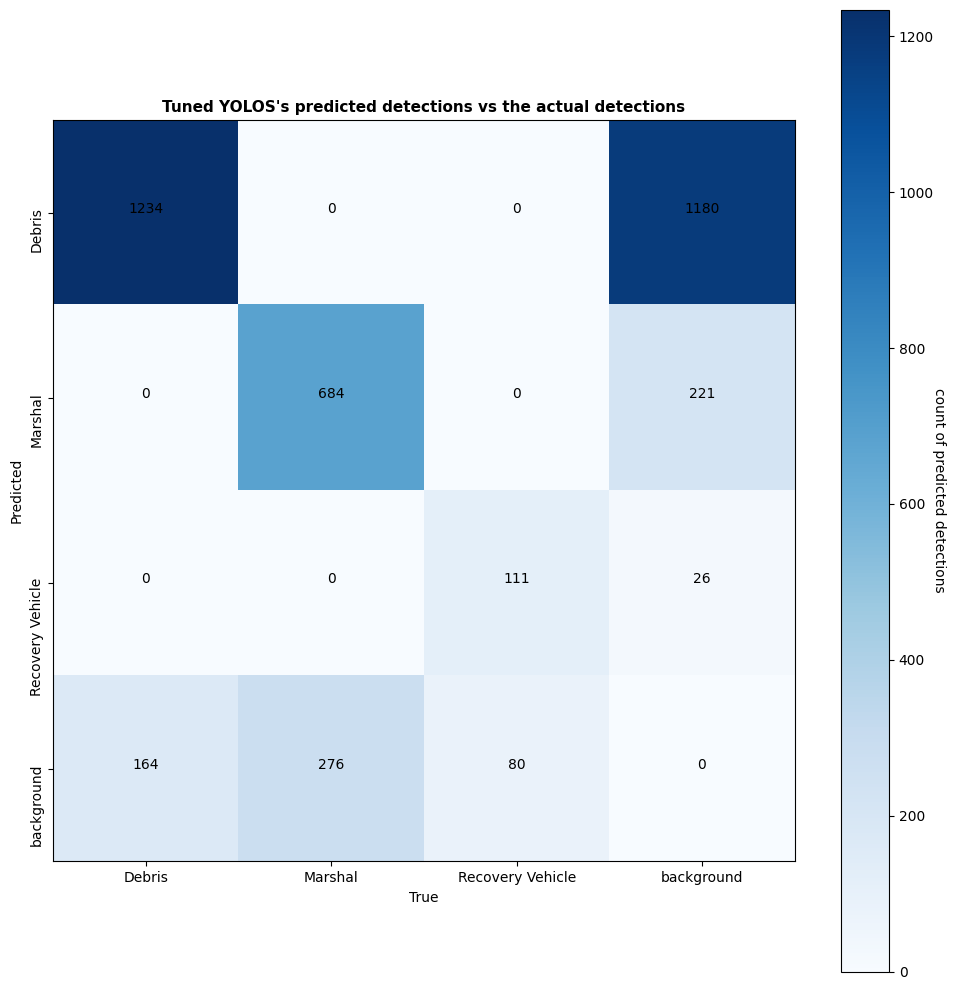

In [66]:
# Feed arrays of actual and predicted into confusion_matrix
cm = confusion_matrix(predicted, actual) 

# Plot confusion matrix 
fig, ax = plt.subplots(figsize=(10,10))
im, cbar = heatmap(cm, categories, categories, ax=ax,
                   cmap=plt.cm.Blues, cbarlabel="count of predicted detections")
texts = annotate_heatmap(im, data=cm)
plt.title("Tuned YOLOS's predicted detections vs the actual detections", fontweight='bold', fontsize=11)

fig.tight_layout()
plt.show()

### Validation

Image #654
Original Image: 


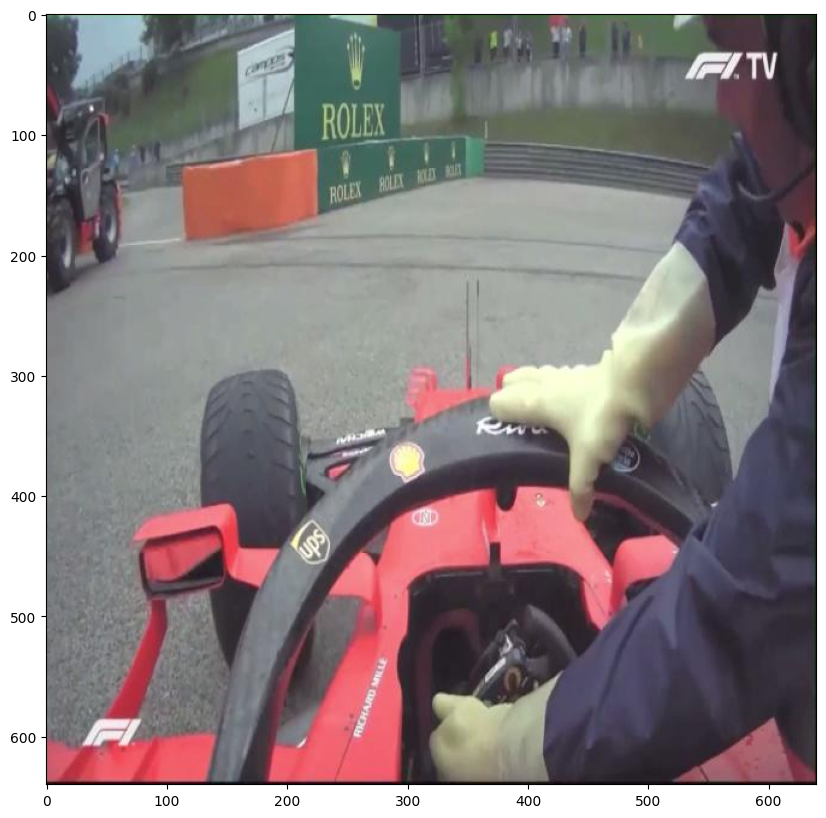

Ground truth: 


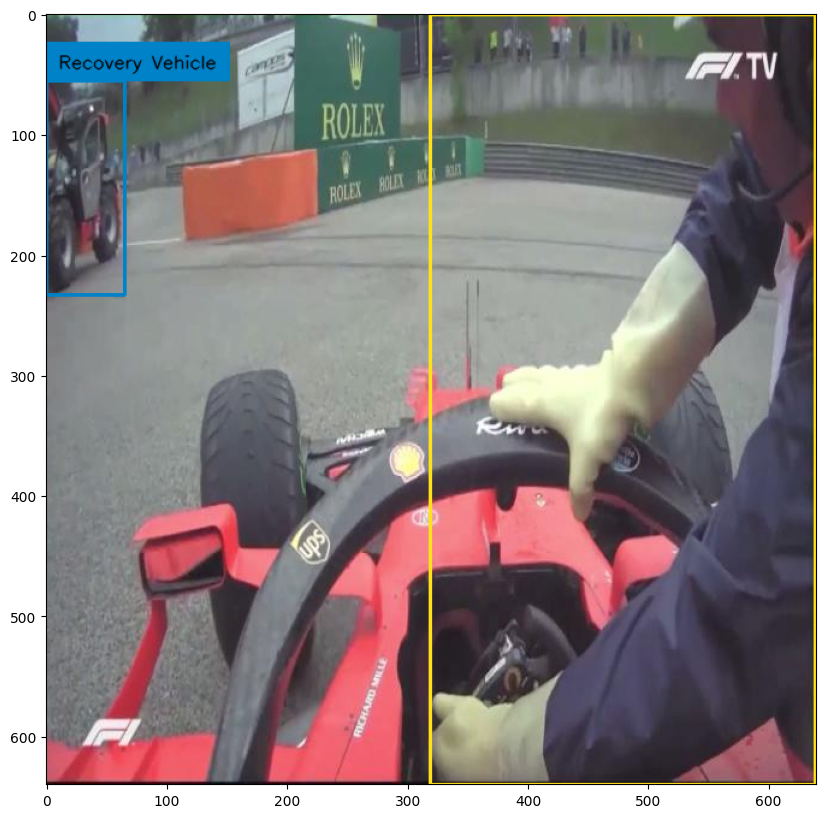

Number of Detections:  2
Prediction: 


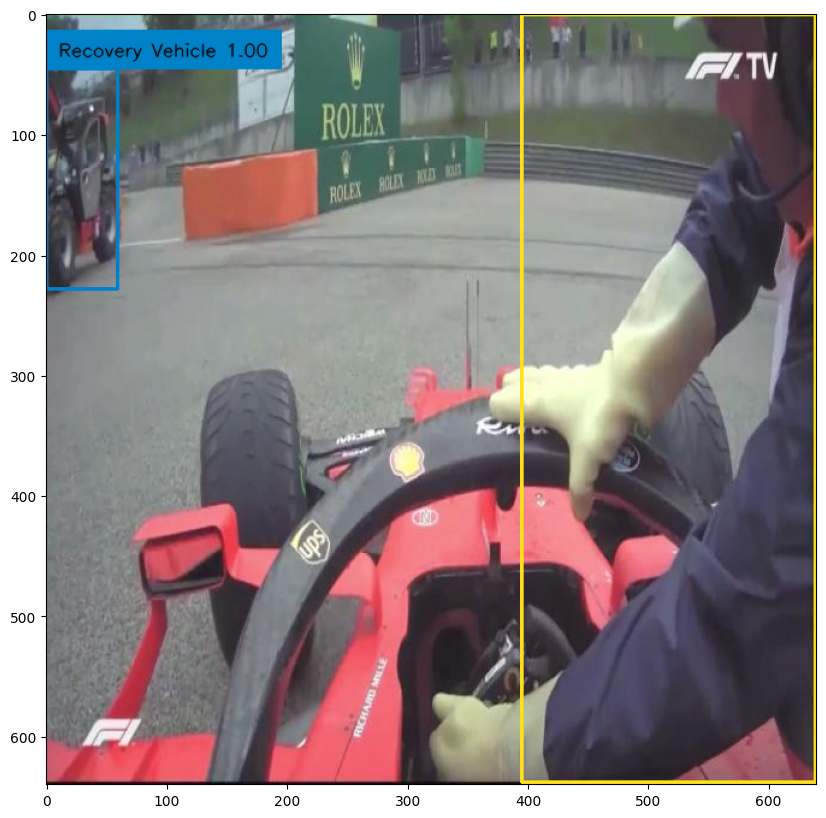

In [67]:
import random
import cv2
import numpy as np
import supervision as sv

device = 'cpu'
CONFIDENCE_THRESHOLD = 0.7
IOU_THRESHOLD = 0.5
image_processor = YolosImageProcessor.from_pretrained(checkpoint)

# utils
categories = val_dataset.coco.cats
id2label = {k: v['name'] for k,v in categories.items()}
box_annotator = sv.BoxAnnotator()

# select random image
image_ids = val_dataset.coco.getImgIds()
image_id = random.choice(image_ids)
print('Image #{}'.format(image_id))

# load image
image = val_dataset.coco.loadImgs(image_id)[0]
annotations = val_dataset.coco.imgToAnns[image_id]
image_path = os.path.join(val_dataset.root, image['file_name'])
image = cv2.imread(image_path)

print('Original Image: ')
%matplotlib inline  
sv.show_frame_in_notebook(image, (10, 10))

# Add ground truth annotations
detections = sv.Detections.from_coco_annotations(coco_annotation=annotations)
labels = [f"{id2label[class_id]}" for _, _, class_id, _ in detections]
frame = box_annotator.annotate(scene=image.copy(), detections=detections, labels=labels)

print('Ground truth: ')
%matplotlib inline  
sv.show_frame_in_notebook(frame, (10, 10))

# inference
with torch.no_grad():

    # load image and predict
    inputs = image_processor(images=image, return_tensors='pt').to(device)
    outputs = model_tuned(**inputs)

    # post-process
    target_sizes = torch.tensor([image.shape[:2]]).to(device)
    results = image_processor.post_process_object_detection(
        outputs=outputs, 
        threshold=CONFIDENCE_THRESHOLD, 
        target_sizes=target_sizes
    )[0]

print('Number of Detections: ', len(results['scores']))

# annotate
if len(results['scores']) == 0 :
  frame = image.copy()
else:
  detections = sv.Detections.from_transformers(transformers_results=results).with_nms(threshold=IOU_THRESHOLD)
  labels = [f"{id2label[class_id]} {confidence:.2f}" for _, confidence, class_id, _ in detections]
  frame = box_annotator.annotate(scene=image.copy(), detections=detections, labels=labels)

print('Prediction: ')
%matplotlib inline  
sv.show_frame_in_notebook(frame, (10, 10))